# Random baseline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch_geometric as pyg
import numpy as np
import random

import networkx as nx

import matplotlib.pyplot as plt

from typing import Type
from gnn_xai_common.datasets import BaseGraphDataset

In [3]:
from gnnboundary import *

In [5]:
def seed_all(random_seed):
    random.seed(random_seed) # only this for random boundary graphs 
    
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
    
    #torch.backends.cudnn.deterministic = True 
    #torch.backends.cudnn.benchmark = False

seed_all(3407)

# Sample function

In [6]:
# !!! limitation: not fully reproducible since BaseGraphDataset doesn't use hashing

def sample_random_boundary_graph(
    region_1: Type[BaseGraphDataset], 
    region_2: Type[BaseGraphDataset], 
    k: int = 1, 
    show: bool = False
) -> nx.Graph:
    """
    Generate a random boundary graph by combining graphs from two regions and adding random edges between them.
    
    Parameters:
        region_1 Type[BaseGraphDataset]: A custonm dataset of graphs classified as class 1.
        region_2 Type[BaseGraphDataset]: A custom dataset of graphs classified as class 2.
        k (int, optional): Number of random edges to add between the graphs from the two regions. Defaults to 1.
        show (bool, optional): Whether to display the combined graph using matplotlib. Defaults to False.
    
    Returns:
        nx.Graph: The combined graph with `k` random edges added between the graphs from the two regions.
    """
    
    # Sample one graph from each decision region
    graph_1 = region_1[random.choice(range(len(region_1)))].G
    graph_2 = region_2[random.choice(range(len(region_2)))].G
    
    # Rename nodes in graph_2 to avoid overlaps
    graph_2_renamed = nx.relabel_nodes(graph_2, lambda x: x + len(graph_1.nodes))
    
    # Combine the two graphs
    combined_graph = nx.union(graph_1, graph_2_renamed)
    
    # Add k random edges between the two graphs
    for _ in range(k):
        node_from_graph_1 = random.choice(list(graph_1.nodes))
        node_from_graph_2 = random.choice(list(graph_2_renamed.nodes))
        combined_graph.add_edge(node_from_graph_1, node_from_graph_2)
    
    # Show the combined graph
    if show:
        plt.figure(figsize=(10, 6))
        pos = nx.spring_layout(combined_graph)  # Position nodes for visualization
        
        # Draw nodes and edges for each graph with different colors
        nx.draw(graph_1, pos, with_labels=True, node_color='blue', edge_color='black', font_weight='bold')
        nx.draw(graph_2_renamed, pos, with_labels=True, node_color='green', edge_color='black', font_weight='bold')
        
        # Highlight the added edges in red
        added_edges = [
            (random.choice(list(graph_1.nodes)), random.choice(list(graph_2_renamed.nodes))) for _ in range(k)
        ]
        nx.draw_networkx_edges(
            combined_graph, pos,
            edgelist=added_edges,
            edge_color='red', width=2
        )
        plt.title(f"Combined Graph with {k} Random Connection(s)", fontsize=14)
        plt.show()
    
    return combined_graph


## Experiment code

In [7]:
def run_random_baseline_experiment(
        cls_1: int, 
        cls_2: int, 
        data: Type[BaseGraphDataset],
        model: GCNClassifier, 
        n_trials: int = 100, 
        show_every: int = 0
        ) -> dict: ## todo
    """
    Evaluate random boundary graphs over multiple trials. 
    
    Results from selected trials and mean results are printed out.
    """

    # Separate data based on decision regions
    dataset_1 = data[cls_1]
    dataset_2 = data[cls_2]

    all_probs = []

    for i in range(n_trials):
        
        G = sample_random_boundary_graph(dataset_1, dataset_2)
        n = G.number_of_nodes()
        m = G.number_of_edges()
        batch = pyg.data.Batch.from_data_list([dataset_2.convert(G, generate_label=False)])
        pred = model(batch)
        logits = pred["logits"].mean(dim=0).tolist()
        probs = pred["probs"].mean(dim=0).tolist()
        all_probs.append(probs)
        if show_every and i % show_every == 0:
            print(f"===Trial {i}===")
            print(f"{n=} {m=}")
            print(f"{logits=}")
            print(f"{probs=}")
            dataset_2.draw(G, ax=None)

    return dict(label=list(dataset_1.GRAPH_CLS.values()),
                mean=np.mean(all_probs, axis=0),
                std=np.std(all_probs, axis=0))
  

# Collab Experiment

In [19]:
dataset = CollabDataset(seed=12345) # todo: decide if sticking with this seed across experiments

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l

In [20]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('ckpts/collab.pt', map_location=torch.device(device)))

/var/folders/x1/dl1z_tcs7zb6pppfbf65d5sh0000gn/T/ipykernel_72756/344992762.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpts/collab

<All keys matched successfully>

In [21]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 0 & 1

===Trial 0===
n=80 m=358
logits=[0.713811457157135, 0.3698531687259674, -5.5365986824035645]
probs=[0.5844917297363281, 0.41438037157058716, 0.0011278719175606966]
===Trial 100===
n=74 m=618
logits=[0.9867108464241028, -5.261178493499756, -4.312440395355225]
probs=[0.9931173324584961, 0.0019212178885936737, 0.004961446858942509]
===Trial 200===
n=109 m=688
logits=[0.6891643404960632, -5.889344215393066, -6.519886493682861]
probs=[0.9978747367858887, 0.001386967021971941, 0.0007382867624983191]
===Trial 300===
n=286 m=2897
logits=[-0.36207330226898193, -9.060128211975098, -19.39068031311035]
probs=[0.9998331069946289, 0.00016688223695382476, 5.4438826779801275e-09]
===Trial 400===
n=84 m=763
logits=[0.9503387212753296, -13.690469741821289, -3.7754178047180176]
probs=[0.9912133812904358, 4.342551562785957e-07, 0.008786119520664215]


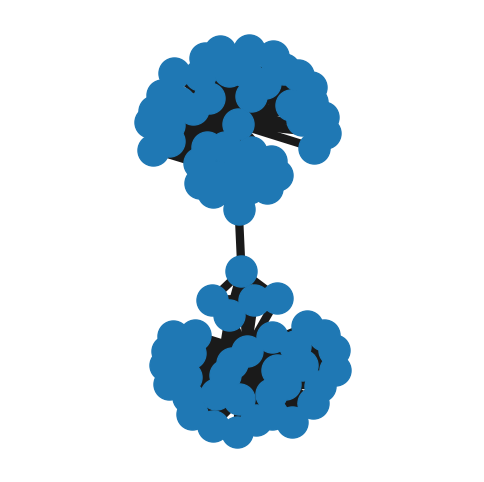

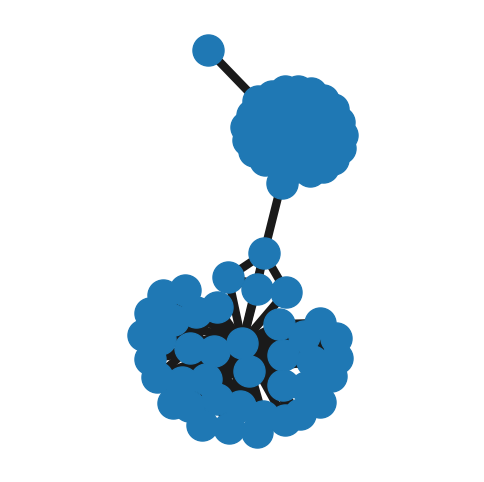

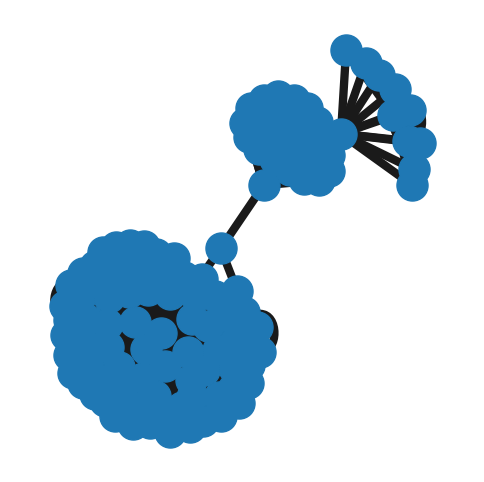

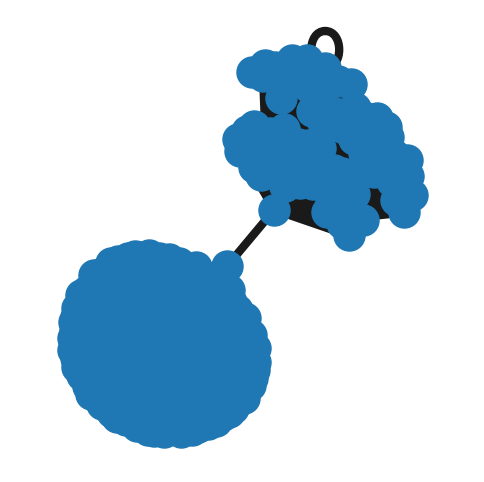

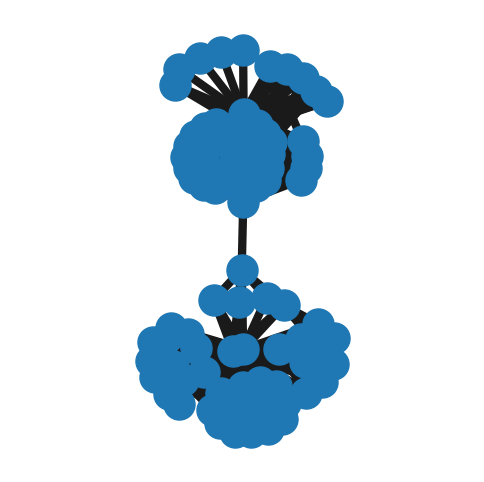

In [22]:
results = run_random_baseline_experiment(cls_1=0, cls_2=1, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [23]:
print(results)

{'label': ['High Energy', 'Condensed Matter', 'Astro'], 'mean': array([0.85330418, 0.14358288, 0.00311294]), 'std': array([0.24052729, 0.24115234, 0.00604314])}


## 0 & 2

===Trial 0===
n=166 m=4421
logits=[-0.11869597434997559, -51.64393615722656, -6.029256343841553]
probs=[0.9972966313362122, 4.1850064986715255e-23, 0.002703338861465454]
===Trial 100===
n=93 m=1689
logits=[-1.8695094585418701, -76.13764953613281, -0.428663969039917]
probs=[0.1914144605398178, 1.0659377263126734e-33, 0.8085855841636658]
===Trial 200===
n=143 m=3793
logits=[-8.028790473937988, -194.41513061523438, 4.389209747314453]
probs=[4.045100013172487e-06, 0.0, 0.9999959468841553]
===Trial 300===
n=166 m=2674
logits=[-2.3841519355773926, -81.2287368774414, -1.6225816011428833]
probs=[0.31830543279647827, 1.8242141254849393e-35, 0.6816945672035217]
===Trial 400===
n=110 m=893
logits=[0.6596513986587524, -5.567667484283447, -5.820744514465332]
probs=[0.9965044260025024, 0.0019678366370499134, 0.0015278443461284041]


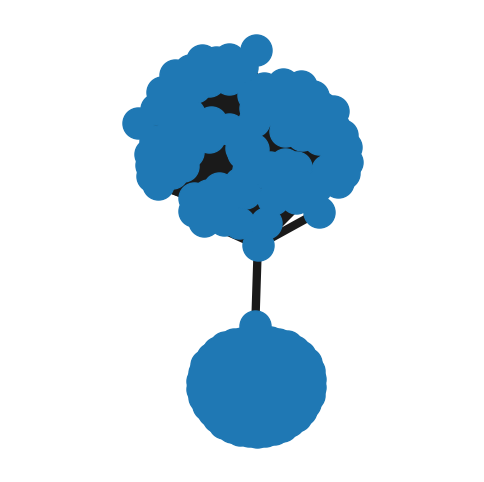

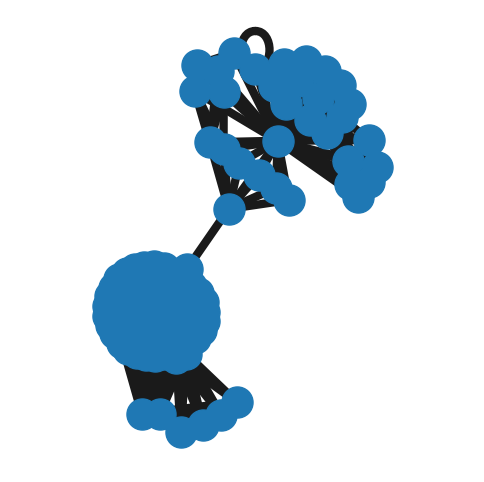

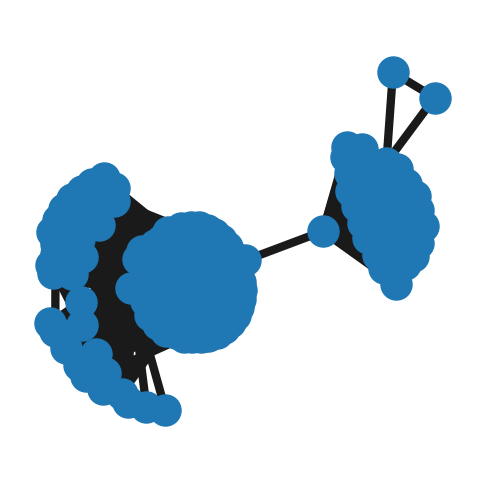

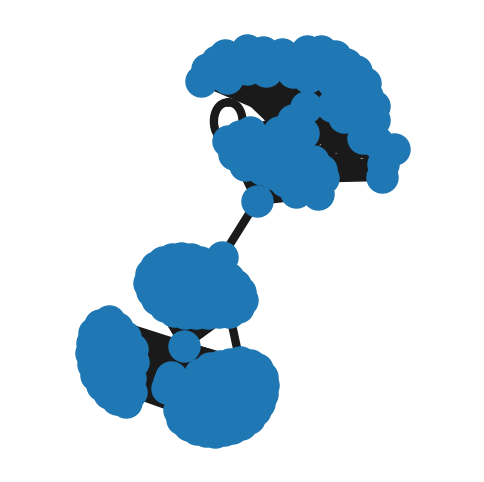

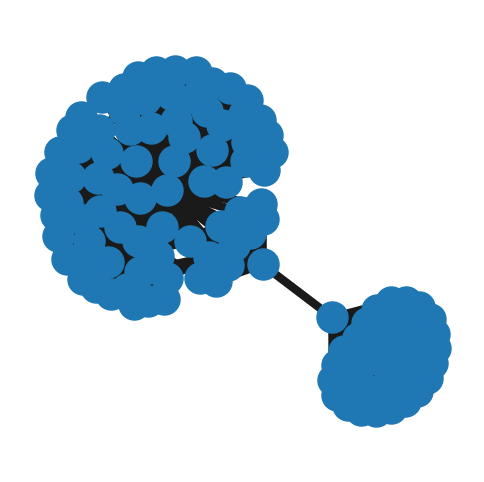

In [24]:
results = run_random_baseline_experiment(cls_1=0, cls_2=2, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [25]:
print(results)

{'label': ['High Energy', 'Condensed Matter', 'Astro'], 'mean': array([0.51208879, 0.00876303, 0.47914817]), 'std': array([0.44642811, 0.06326979, 0.45118974])}


# Motif experiment

In [26]:
dataset = MotifDataset(seed=12345) 
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=6,
                      num_layers=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('ckpts/motif.pt', map_location=torch.device(device)))

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l

<All keys matched successfully>

In [29]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 0 & 1

===Trial 0===
n=116 m=153
logits=[-27.501434326171875, 9.896467208862305, 0.26153016090393066, -11.445093154907227]
probs=[5.731502038899917e-17, 0.9999345541000366, 6.53990573482588e-05, 5.388274271211912e-10]
===Trial 100===
n=145 m=203
logits=[-30.241737365722656, 10.384881973266602, -5.099871635437012, -11.838345527648926]
probs=[2.2703045178362632e-18, 0.9999997615814209, 1.8838956350464287e-07, 2.2313845216004324e-10]
===Trial 200===
n=107 m=151
logits=[-24.544898986816406, 9.405776977539062, -10.806741714477539, -5.537443161010742]
probs=[1.800564193999831e-15, 0.9999996423721313, 1.6665353541611694e-09, 3.2377386105508776e-07]
===Trial 300===
n=41 m=60
logits=[-14.59465503692627, 6.85366153717041, -8.17398738861084, -1.8152412176132202]
probs=[4.842166112517532e-10, 0.9998278617858887, 2.975090751533571e-07, 0.00017181802832055837]
===Trial 400===
n=144 m=189
logits=[-24.404678344726562, 7.941981315612793, -7.826312065124512, -10.254277229309082]
probs=[8.954136904322767e-15, 0

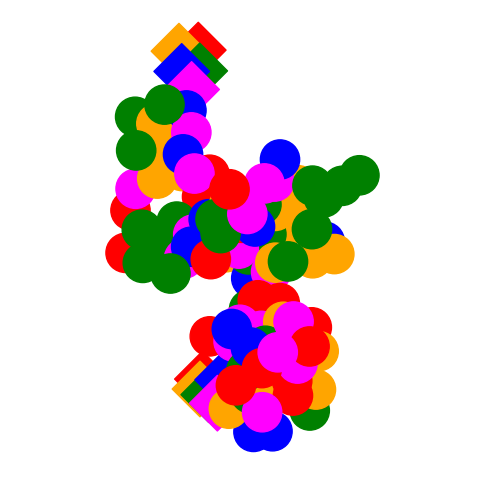

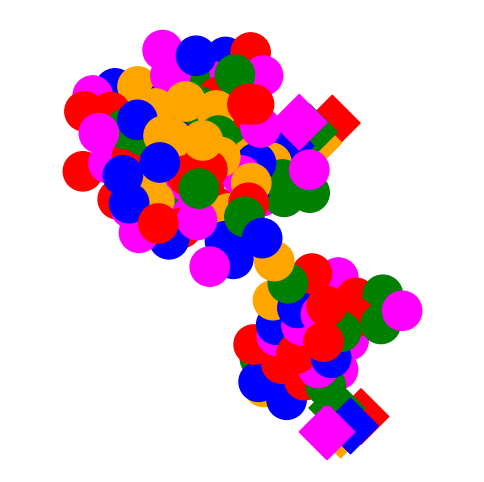

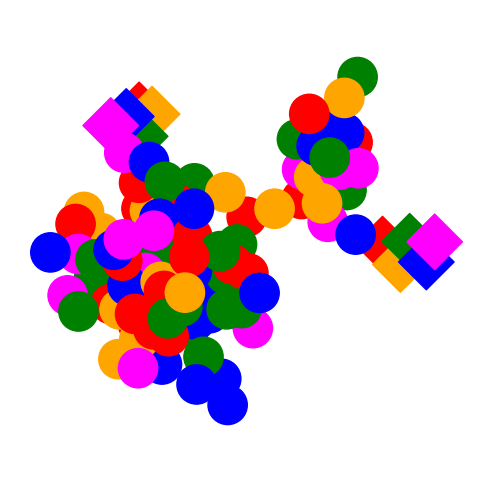

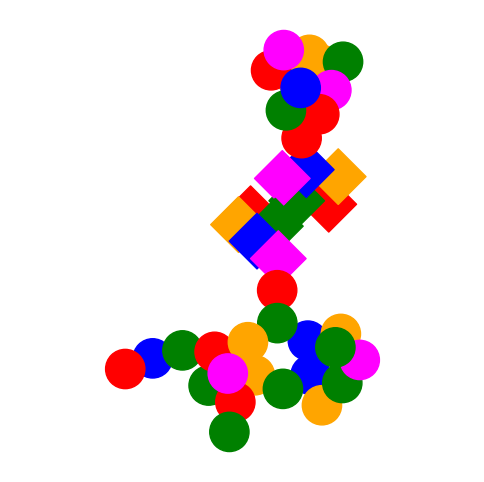

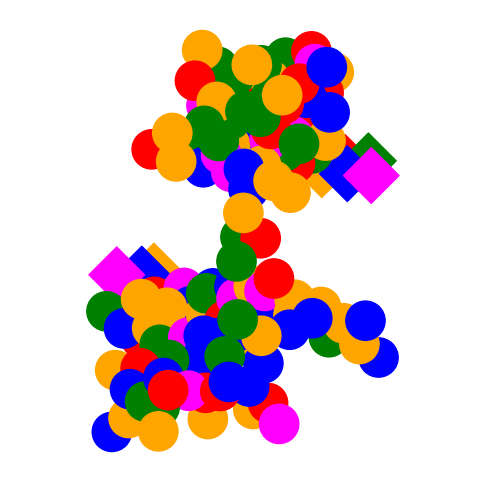

In [30]:
results = run_random_baseline_experiment(cls_1=0, cls_2=1, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [31]:
print(results)

{'label': ['house', 'house_x', 'comp_4', 'comp_5'], 'mean': array([1.73617811e-02, 9.72760942e-01, 6.03244193e-05, 9.81695907e-03]), 'std': array([0.12003342, 0.15079435, 0.00126514, 0.08574651])}


### 0 & 2

===Trial 0===
n=35 m=46
logits=[-26.707630157470703, 10.101503372192383, 22.214462280273438, -16.461719512939453]
probs=[5.667647282860495e-22, 5.487902853928972e-06, 0.9999945163726807, 1.596413087293653e-17]
===Trial 100===
n=174 m=248
logits=[-41.1505126953125, 13.193296432495117, 22.550373077392578, -25.54283332824707]
probs=[2.162814994204491e-28, 8.634472033008933e-05, 0.9999136924743652, 1.2982176632139081e-21]
===Trial 200===
n=127 m=184
logits=[-36.2544059753418, 12.466297149658203, 27.97493553161621, -22.957727432250977]
probs=[1.2751230679573038e-28, 1.8394324285964103e-07, 0.9999997615814209, 7.589714072842946e-23]
===Trial 300===
n=93 m=126
logits=[-31.75130844116211, 11.43885612487793, 26.09780502319336, -19.77076530456543]
probs=[7.524004321090371e-26, 4.302285105950432e-07, 0.9999995231628418, 1.2009740801810076e-20]
===Trial 400===
n=125 m=174
logits=[-5.22695255279541, -1.5828981399536133, -9.22525405883789, -11.373344421386719]
probs=[0.02546662464737892, 0.974011540

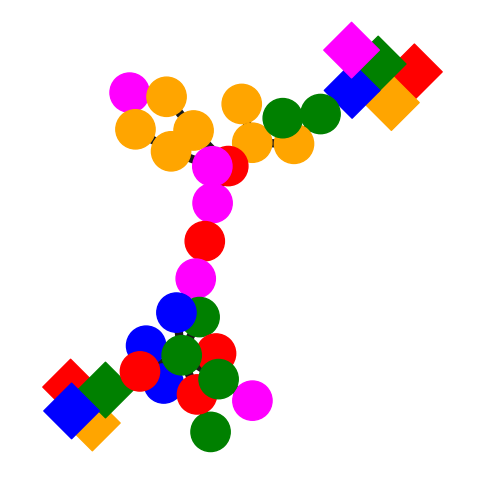

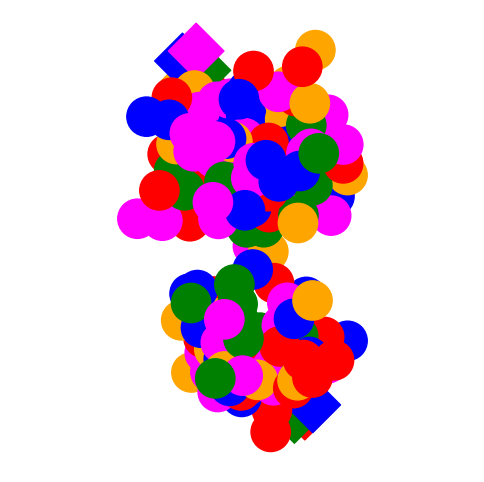

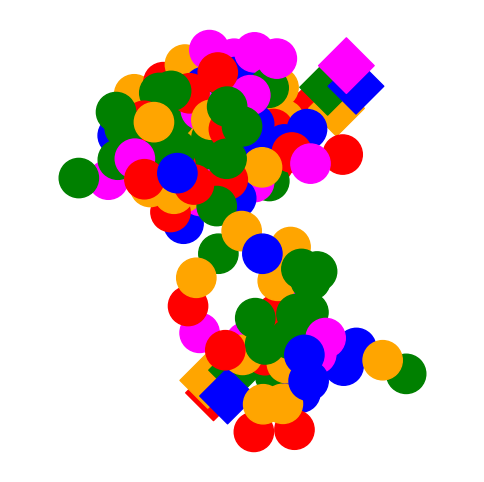

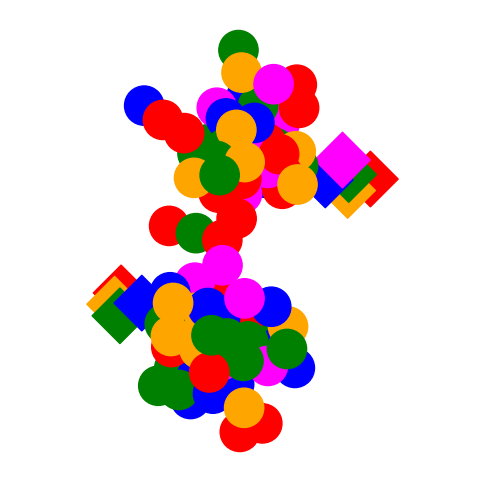

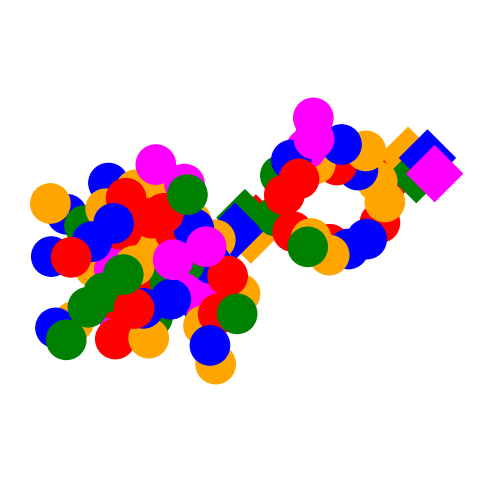

In [32]:
results = run_random_baseline_experiment(cls_1=0, cls_2=2, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [33]:
print(results)

{'label': ['house', 'house_x', 'comp_4', 'comp_5'], 'mean': array([2.00436913e-04, 4.89270073e-02, 9.50871659e-01, 8.97411573e-07]), 'std': array([2.41850633e-03, 1.98204940e-01, 1.99137324e-01, 1.02314470e-05])}


### 1 & 3

===Trial 0===
n=76 m=102
logits=[-35.39849090576172, 14.818521499633789, -31.589035034179688, 6.514166831970215]
probs=[1.552108191047094e-22, 0.9997525811195374, 7.004024205409184e-21, 0.0002473757485859096]
===Trial 100===
n=77 m=116
logits=[-13.025956153869629, 3.6578588485717773, -42.96965408325195, 8.29787540435791]
probs=[5.432547744987914e-10, 0.009565162472426891, 5.378004947713969e-23, 0.9904348850250244]
===Trial 200===
n=103 m=138
logits=[-45.36672592163086, 18.520009994506836, -39.85658645629883, 9.100517272949219]
probs=[1.7960098399750326e-28, 0.9999188184738159, 4.439477446692946e-26, 8.112057548714802e-05]
===Trial 300===
n=102 m=158
logits=[-38.41535949707031, 15.441347122192383, -37.838226318359375, 6.528426647186279]
probs=[4.076353925182267e-24, 0.9998654127120972, 7.25968259577452e-24, 0.0001346200006082654]
===Trial 400===
n=148 m=200
logits=[-32.410667419433594, 10.864830017089844, -35.8504753112793, 1.5064994096755981]
probs=[1.6056572183798452e-19, 0.9999138116

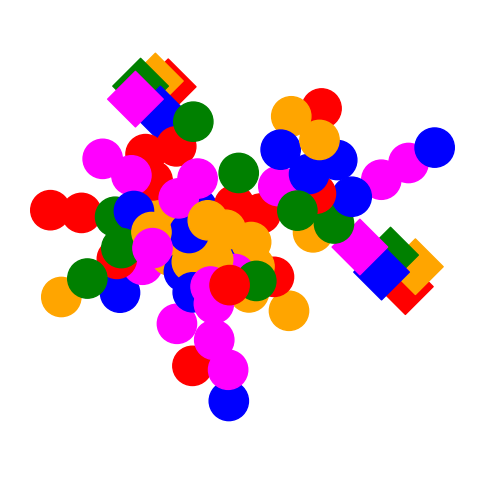

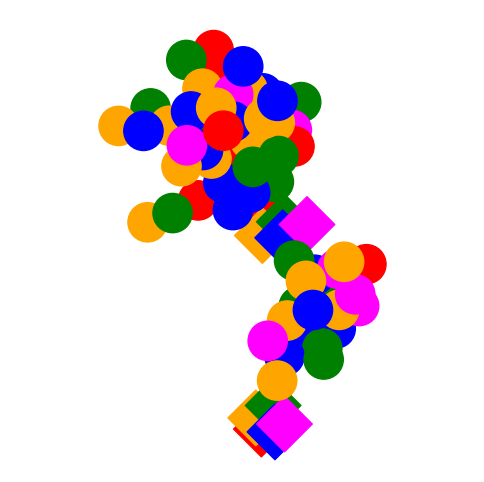

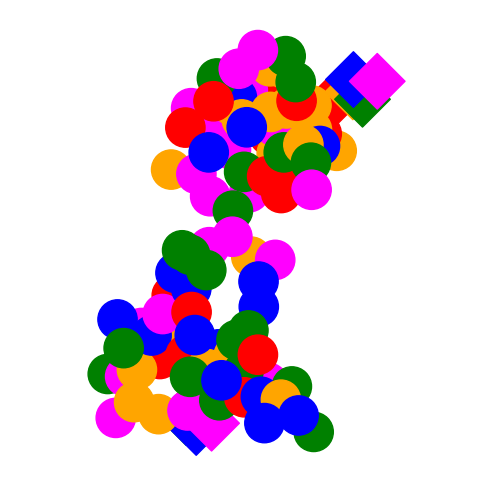

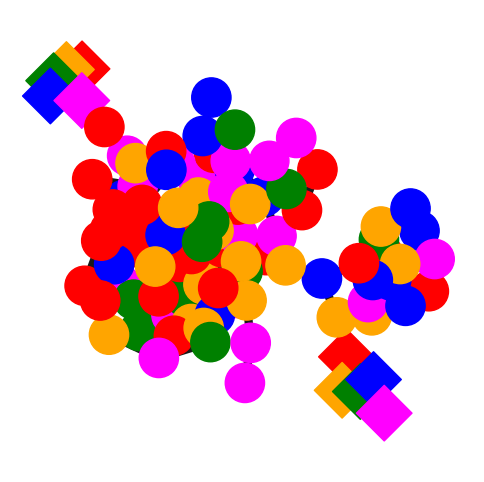

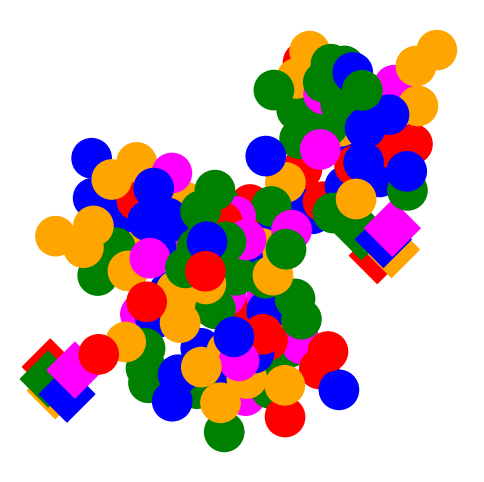

In [34]:
results = run_random_baseline_experiment(cls_1=1, cls_2=3, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [35]:
print(results)

{'label': ['house', 'house_x', 'comp_4', 'comp_5'], 'mean': array([2.31441038e-11, 9.39187708e-01, 3.47427011e-15, 6.08122904e-02]), 'std': array([3.00622803e-10, 2.19390588e-01, 7.37032884e-14, 2.19390587e-01])}


# Enzymes experiment

In [36]:
dataset = ENZYMESDataset(seed=12345)
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=32,
                      num_layers=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('ckpts/enzymes.pt', map_location=torch.device(device)))

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l

<All keys matched successfully>

In [37]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 0 & 3

===Trial 0===
n=67 m=143
logits=[-18.1373291015625, -15.33716106414795, -19.985055923461914, -12.987321853637695, -14.706921577453613, -18.660877227783203]
probs=[0.004514277447015047, 0.07424817979335785, 0.0007114275940693915, 0.7784093022346497, 0.1394425630569458, 0.0026743251364678144]
===Trial 100===
n=102 m=183
logits=[-18.012977600097656, -34.637840270996094, -39.671775817871094, -19.888465881347656, -21.230560302734375, -30.767736434936523]
probs=[0.8379877805709839, 5.0483745184237705e-08, 3.288070649087871e-10, 0.12844686210155487, 0.033562883734703064, 2.420562395855086e-06]
===Trial 200===
n=83 m=159
logits=[-11.146496772766113, -11.922654151916504, -5.701766490936279, -16.089101791381836, -5.061767578125, -9.656098365783691]
probs=[0.0014781050849705935, 0.0006801808485761285, 0.34223276376724243, 1.0547734746069182e-05, 0.64903724193573, 0.006561107002198696]
===Trial 300===
n=74 m=163
logits=[-12.638884544372559, -16.55889129638672, -13.543976783752441, -12.226525306701

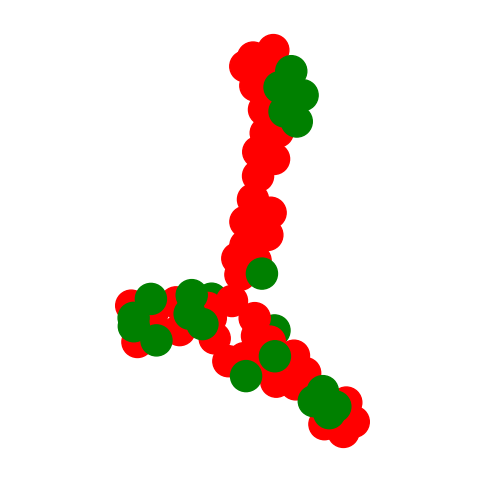

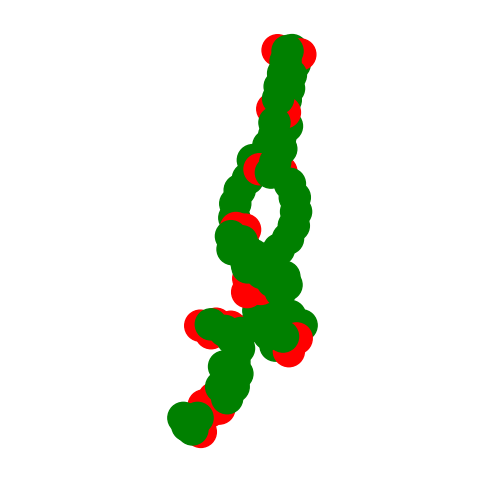

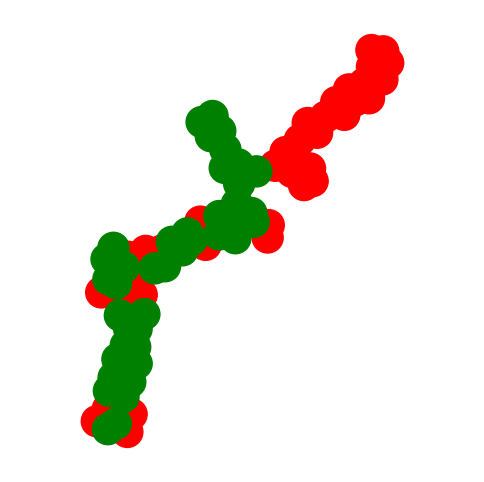

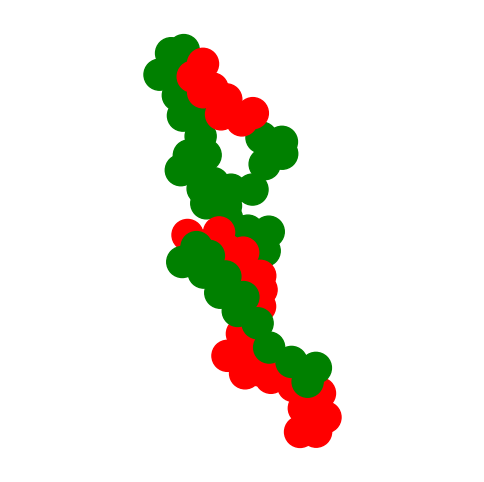

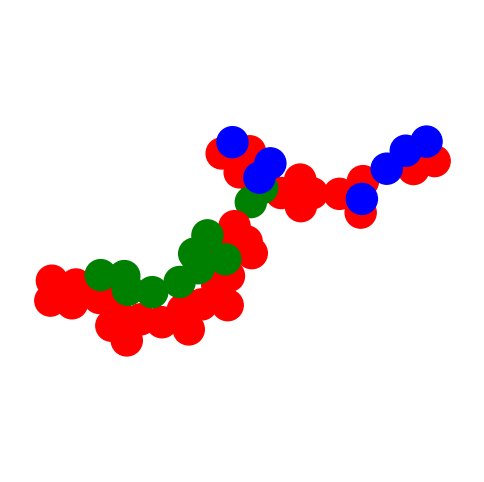

In [38]:
results = run_random_baseline_experiment(cls_1=0, cls_2=3, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [39]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.13997997, 0.13040403, 0.08558577, 0.28119812, 0.2358849 ,
       0.12694722]), 'std': array([0.19042638, 0.23733902, 0.19638356, 0.34684074, 0.27910838,
       0.21347151])}


### 0 & 4

===Trial 0===
n=29 m=56
logits=[-9.8793363571167, -38.476497650146484, -24.534025192260742, -9.794550895690918, -8.799322128295898, -9.960034370422363]
probs=[0.1679070144891739, 6.389685194797476e-14, 7.254681122503825e-08, 0.18276400864124298, 0.49443936347961426, 0.1548895537853241]
===Trial 100===
n=148 m=193
logits=[-28.2374210357666, -54.64887237548828, -45.94672775268555, -21.762348175048828, -28.957687377929688, -43.4048957824707]
probs=[0.0015378626994788647, 5.206789030286858e-15, 3.13229997495057e-11, 0.9977138042449951, 0.0007483587833121419, 3.978936347071027e-10]
===Trial 200===
n=47 m=80
logits=[-8.72419548034668, -14.562291145324707, -17.511962890625, -9.332050323486328, -10.578120231628418, -14.614855766296387]
probs=[0.585832953453064, 0.0017073440831154585, 8.939122926676646e-05, 0.318996399641037, 0.09175390005111694, 0.0016199161764234304]
===Trial 300===
n=89 m=183
logits=[-15.261759757995605, -16.349061965942383, -11.481295585632324, -17.029104232788086, -11.6795

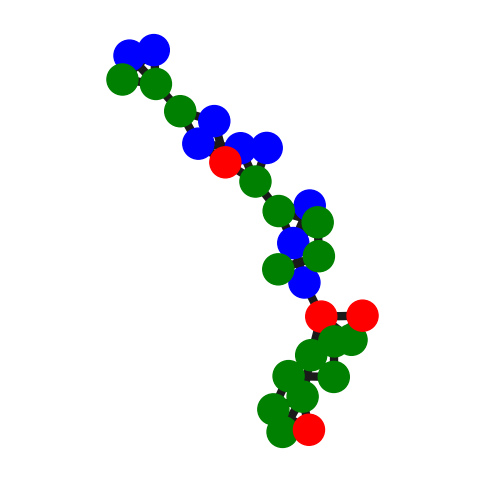

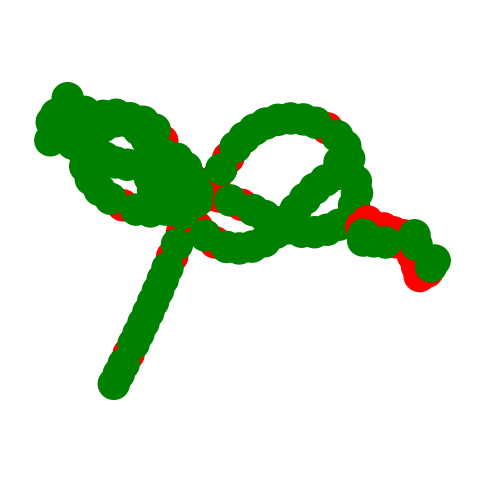

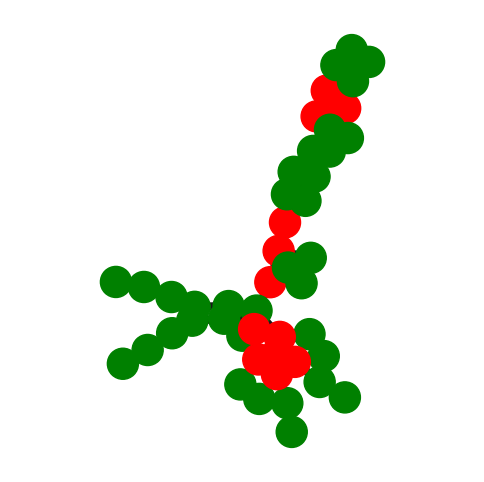

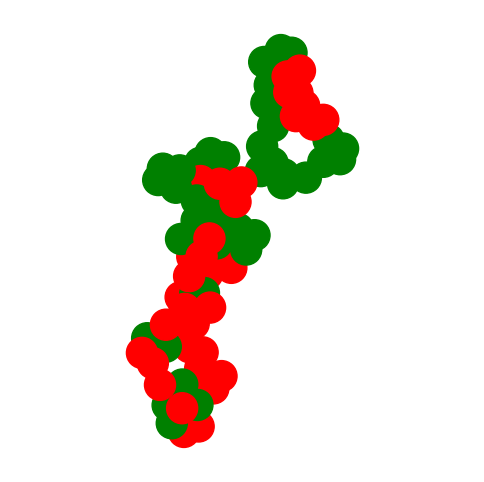

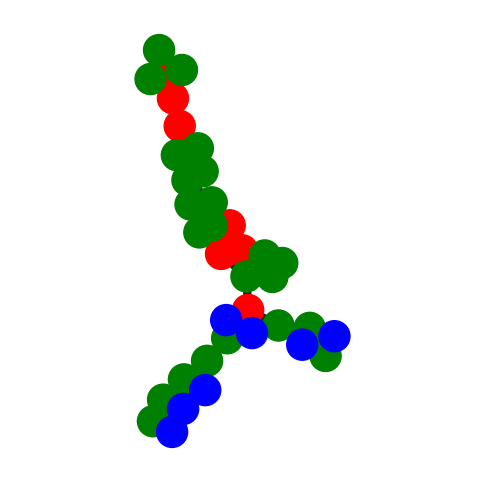

In [40]:
results = run_random_baseline_experiment(cls_1=0, cls_2=4, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [41]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.23067678, 0.11480557, 0.09460227, 0.12601948, 0.31538653,
       0.11850936]), 'std': array([0.29156852, 0.21983914, 0.18629915, 0.23365049, 0.31048894,
       0.19236882])}


### 0 & 5 

===Trial 0===
n=39 m=83
logits=[-5.868872165679932, -4.772876262664795, -7.468106269836426, -11.904149055480957, -8.428441047668457, -6.332769870758057]
probs=[0.20396628975868225, 0.6103000044822693, 0.04121163487434387, 0.0004880574706476182, 0.015774359926581383, 0.12825968861579895]
===Trial 100===
n=78 m=138
logits=[-12.680203437805176, -23.306230545043945, -22.219697952270508, -11.60533332824707, -15.361696243286133, -20.77350616455078]
probs=[0.2500953674316406, 6.071285952202743e-06, 1.7995163943851367e-05, 0.732682466506958, 0.017121747136116028, 7.642385025974363e-05]
===Trial 200===
n=46 m=95
logits=[-9.924942970275879, -11.570243835449219, -13.206133842468262, -9.054726600646973, -9.622564315795898, -9.539350509643555]
probs=[0.15524277091026306, 0.02995479106903076, 0.005834562238305807, 0.37063083052635193, 0.21005485951900482, 0.22828219830989838]
===Trial 300===
n=75 m=128
logits=[-13.207961082458496, -10.914992332458496, -16.343982696533203, -20.269094467163086, -13.20

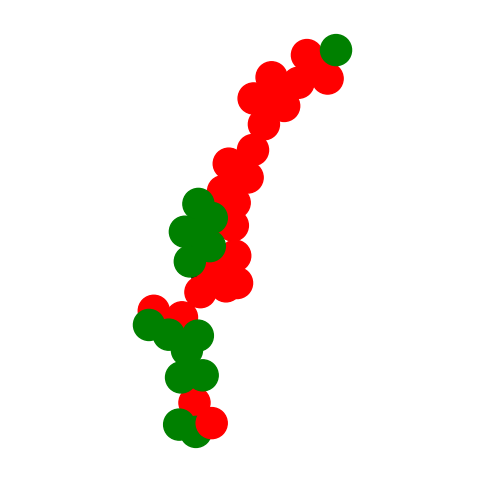

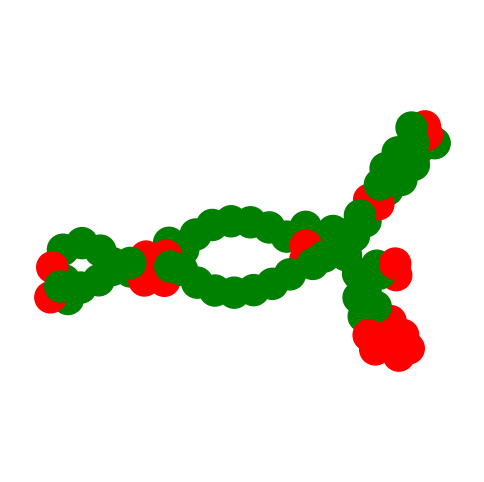

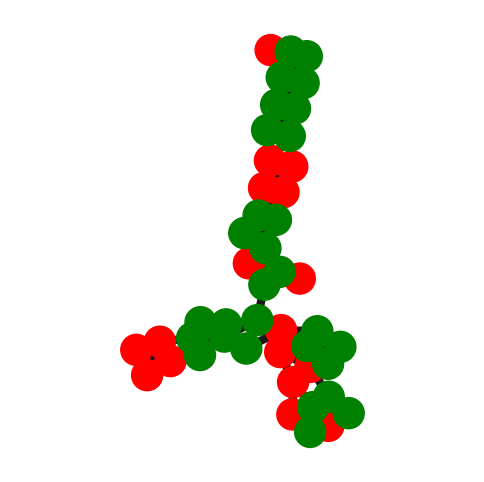

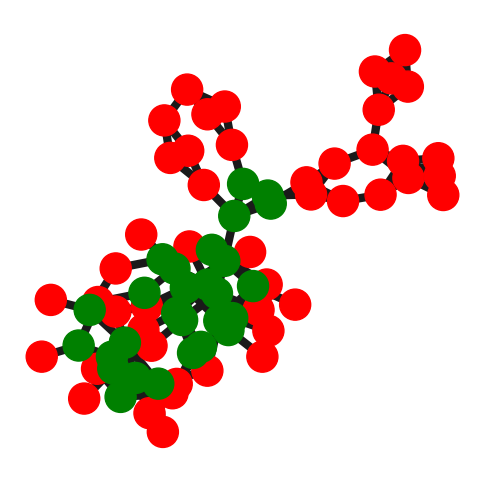

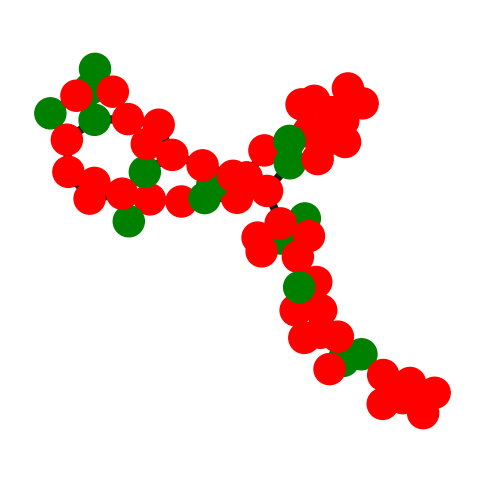

In [42]:
results = run_random_baseline_experiment(cls_1=0, cls_2=5, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [43]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.15391749, 0.17567069, 0.04843886, 0.21972193, 0.22142429,
       0.18082674]), 'std': array([0.18792187, 0.2543214 , 0.09944335, 0.31894028, 0.27066738,
       0.21666463])}


### 1 & 2 

===Trial 0===
n=86 m=180
logits=[-11.902095794677734, -12.087374687194824, -15.021918296813965, -20.854511260986328, -12.215282440185547, -14.51030445098877]
probs=[0.3731417655944824, 0.31003323197364807, 0.01647980883717537, 4.8293561121681705e-05, 0.2728089690208435, 0.02748800627887249]
===Trial 100===
n=62 m=121
logits=[-10.944244384765625, -12.467497825622559, -9.44053840637207, -12.798689842224121, -7.0126543045043945, -7.694890975952148]
probs=[0.01210147887468338, 0.0026381404604762793, 0.05443643406033516, 0.0018943622708320618, 0.6170300841331482, 0.3118995130062103]
===Trial 200===
n=40 m=71
logits=[-7.27084493637085, -6.763224124908447, -5.837634563446045, -8.35305118560791, -6.060959339141846, -4.706742763519287]
probs=[0.04249097779393196, 0.07059169560670853, 0.1781279593706131, 0.014397945255041122, 0.14247652888298035, 0.5519149303436279]
===Trial 300===
n=77 m=152
logits=[-11.313873291015625, -9.732037544250488, -12.956911087036133, -20.22327995300293, -11.5779390335

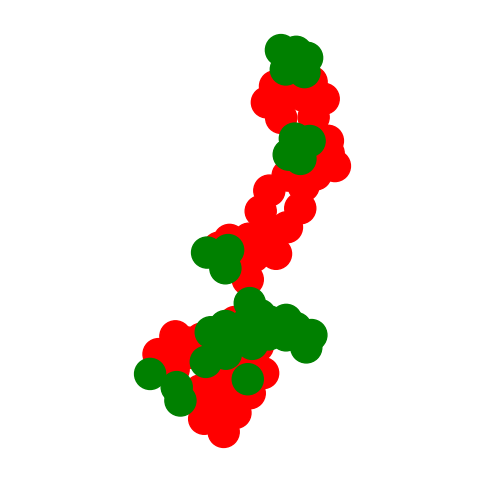

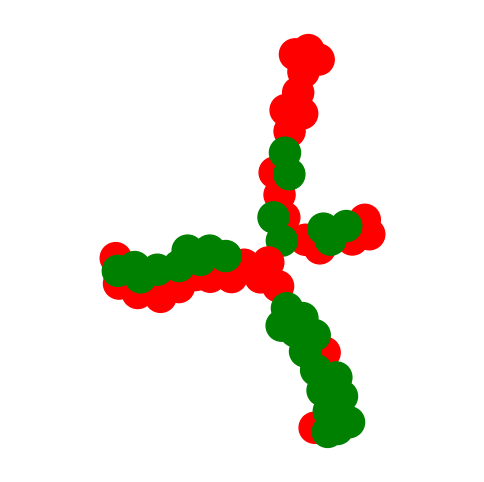

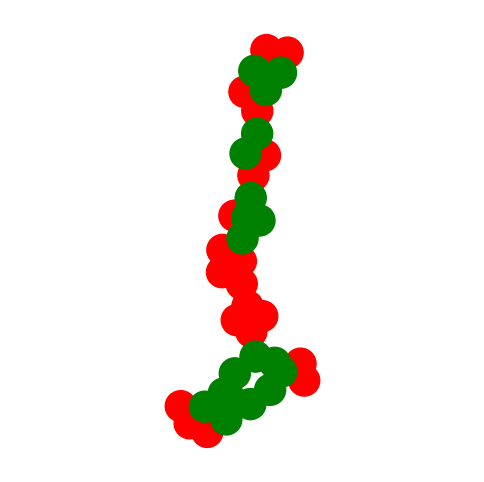

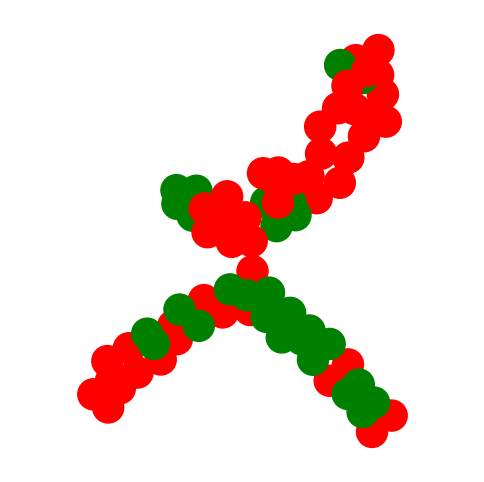

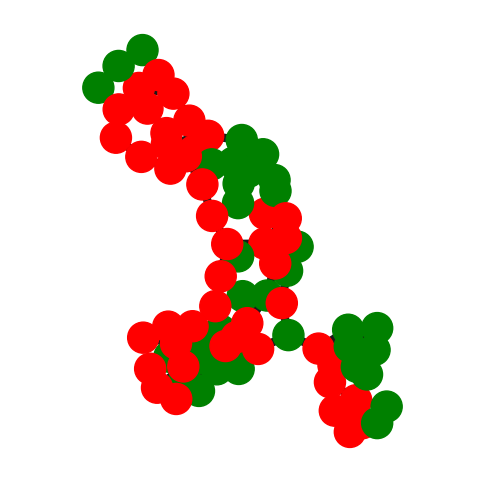

In [44]:
results = run_random_baseline_experiment(cls_1=1, cls_2=2, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [45]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.12371212, 0.16785248, 0.22554665, 0.04190064, 0.34550663,
       0.09548148]), 'std': array([0.17929049, 0.21267467, 0.25215973, 0.13770488, 0.282858  ,
       0.12702841])}


### 1 & 5 

===Trial 0===
n=50 m=90
logits=[-8.449797630310059, -7.230450630187988, -9.402206420898438, -14.194226264953613, -9.167004585266113, -8.270988464355469]
probs=[0.15484926104545593, 0.5241611003875732, 0.05974247679114342, 0.0004956047632731497, 0.0755840390920639, 0.1851675808429718]
===Trial 100===
n=83 m=154
logits=[-13.385852813720703, -12.282862663269043, -12.484991073608398, -17.30988121032715, -10.00768756866455, -11.911988258361816]
probs=[0.02488945610821247, 0.0749959722161293, 0.06127095967531204, 0.0004918486811220646, 0.7296825051307678, 0.10866924375295639]
===Trial 200===
n=53 m=101
logits=[-12.300836563110352, -11.504054069519043, -11.190417289733887, -14.90274715423584, -9.738669395446777, -7.422791004180908]
probs=[0.006637211423367262, 0.014723935164511204, 0.020148122683167458, 0.0004920284845866263, 0.08604402095079422, 0.8719546794891357]
===Trial 300===
n=52 m=104
logits=[-8.541289329528809, -7.897497177124023, -9.295642852783203, -11.371866226196289, -7.521830558

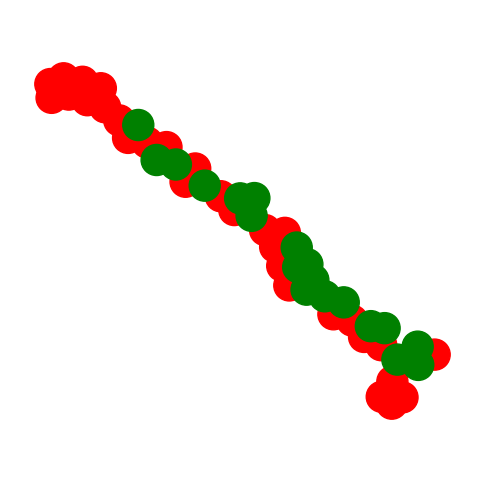

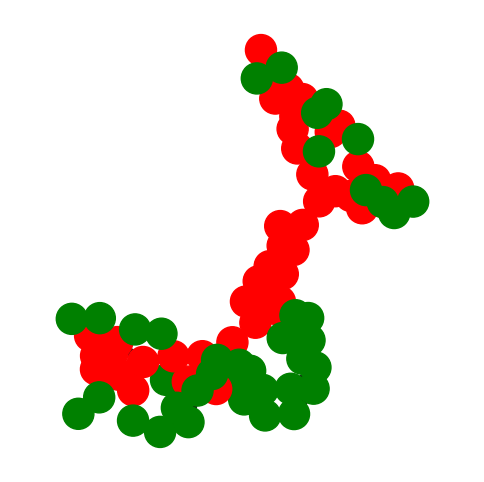

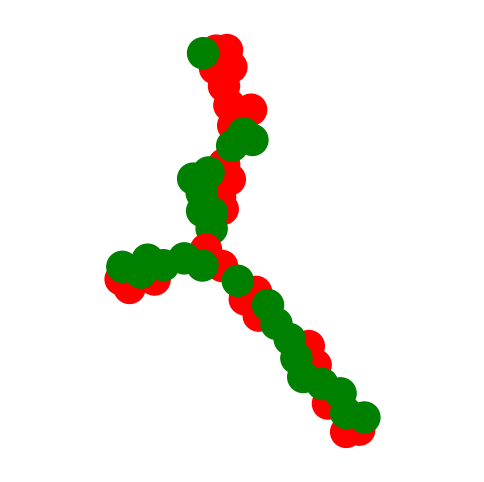

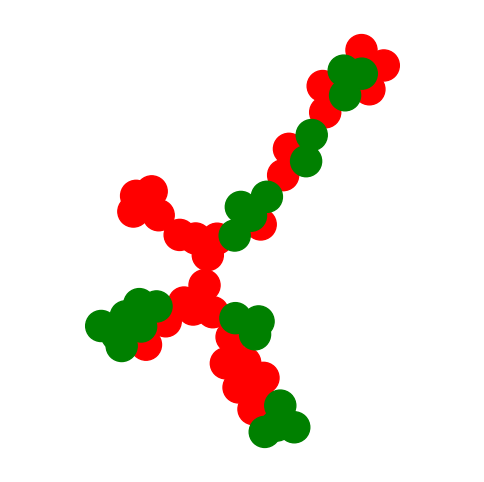

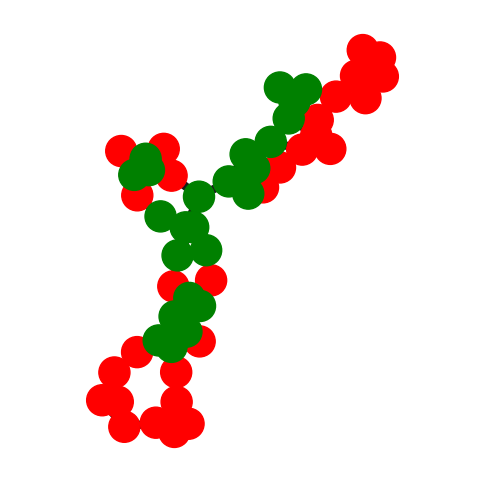

In [46]:
results = run_random_baseline_experiment(cls_1=1, cls_2=5, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [47]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.11263556, 0.25709148, 0.06141592, 0.05321885, 0.23629496,
       0.27934323]), 'std': array([0.12690674, 0.26125244, 0.11704894, 0.14018778, 0.23379576,
       0.25929686])}


### 2 & 4

===Trial 0===
n=87 m=164
logits=[-14.39151668548584, -15.377081871032715, -12.70604133605957, -17.460023880004883, -9.369604110717773, -10.648311614990234]
probs=[0.004981344565749168, 0.001859178300946951, 0.026874424889683723, 0.00023158521798904985, 0.755675733089447, 0.2103777825832367]
===Trial 100===
n=58 m=128
logits=[-15.555183410644531, -74.3749008178711, -33.20288848876953, -22.20233726501465, -12.037760734558105, -15.221000671386719]
probs=[0.027704235166311264, 7.897104810677296e-28, 6.001304453384648e-10, 3.595207090256736e-05, 0.9335625767707825, 0.03869723156094551]
===Trial 200===
n=41 m=68
logits=[-10.058968544006348, -13.739602088928223, -9.681079864501953, -9.496989250183105, -7.862180233001709, -12.877604484558105]
probs=[0.07522014528512955, 0.0018960742745548487, 0.10976128280162811, 0.13194674253463745, 0.6766860485076904, 0.004489687737077475]
===Trial 300===
n=32 m=62
logits=[-6.327079772949219, -9.130946159362793, -6.7682623863220215, -5.046326637268066, -6.67

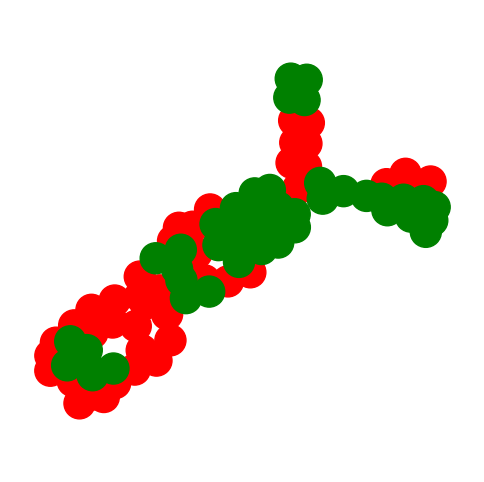

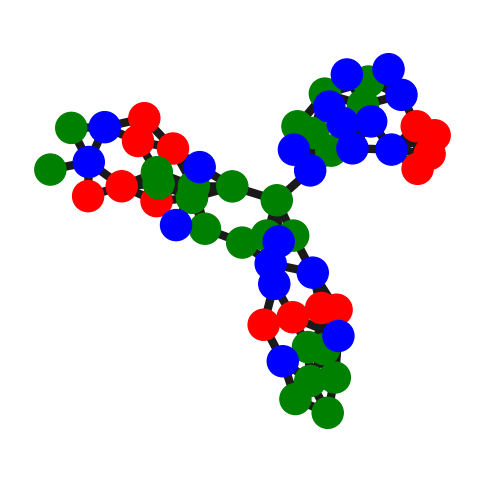

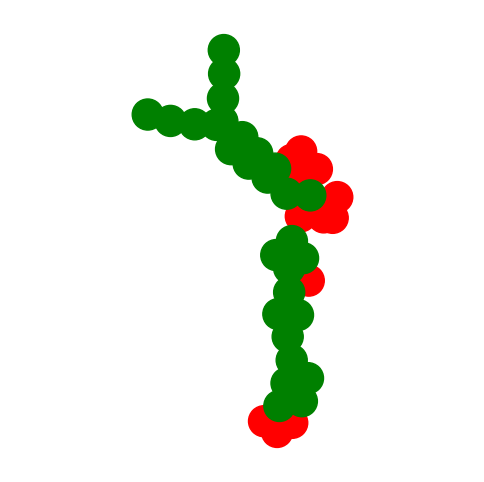

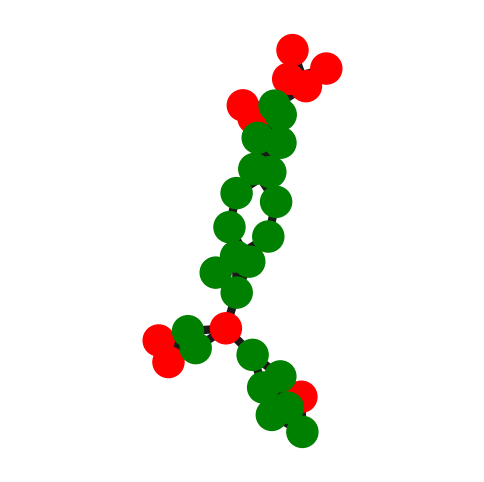

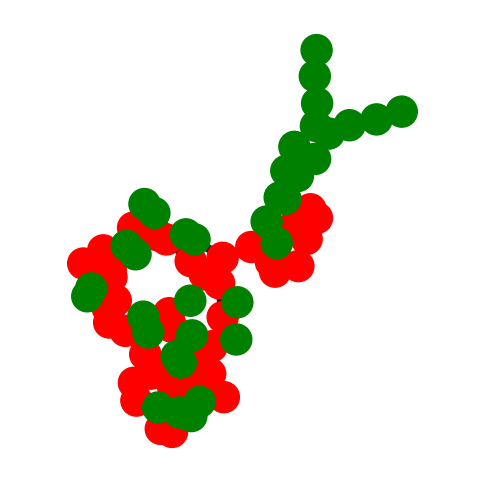

In [48]:
results = run_random_baseline_experiment(cls_1=2, cls_2=4, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [49]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.09199182, 0.03286889, 0.18925517, 0.16885189, 0.43495319,
       0.08207904]), 'std': array([0.14322428, 0.0695891 , 0.25876616, 0.27156957, 0.32720251,
       0.12807379])}


###  3 & 4 

===Trial 0===
n=53 m=106
logits=[-8.728174209594727, -15.893644332885742, -12.226902961730957, -6.555099010467529, -10.749605178833008, -12.797503471374512]
probs=[0.10034295171499252, 7.754663238301873e-05, 0.003033949062228203, 0.8815388083457947, 0.013292007148265839, 0.0017147453036159277]
===Trial 100===
n=77 m=152
logits=[-15.694633483886719, -50.54635238647461, -28.245389938354492, -12.447930335998535, -5.621970176696777, -7.4147491455078125]
probs=[3.615719833760522e-05, 2.644149228656956e-20, 1.2807668814396322e-10, 0.0009294371120631695, 0.8564398288726807, 0.14259453117847443]
===Trial 200===
n=60 m=122
logits=[-10.796610832214355, -13.815751075744629, -8.841169357299805, -10.76947021484375, -9.62187671661377, -10.688396453857422]
probs=[0.07410172373056412, 0.0036193649284541607, 0.5236797332763672, 0.07614043354988098, 0.23988819122314453, 0.08257056027650833]
===Trial 300===
n=60 m=115
logits=[-9.946778297424316, -24.0082950592041, -16.704133987426758, -7.066996097564697,

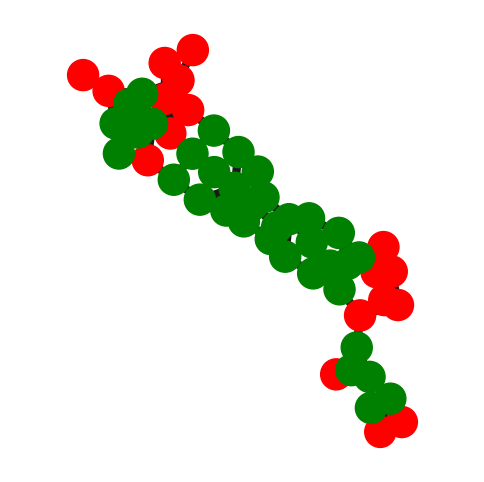

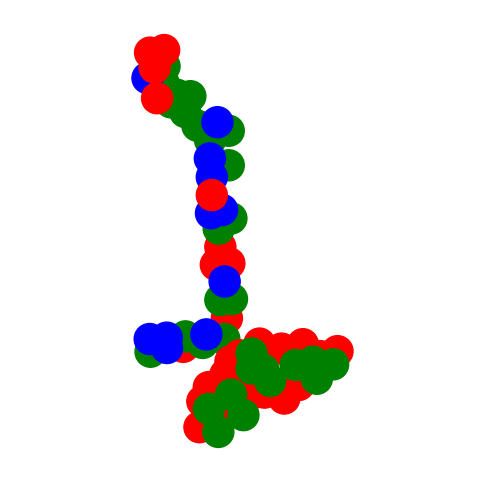

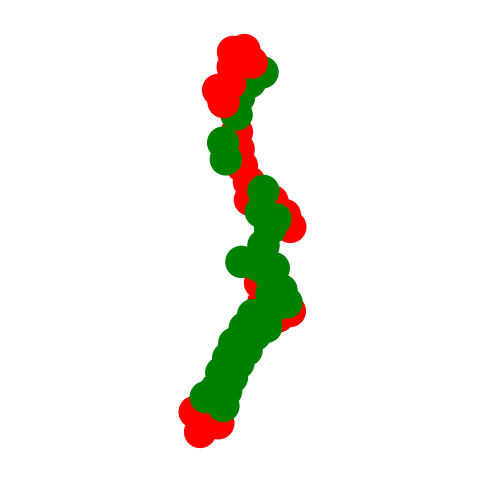

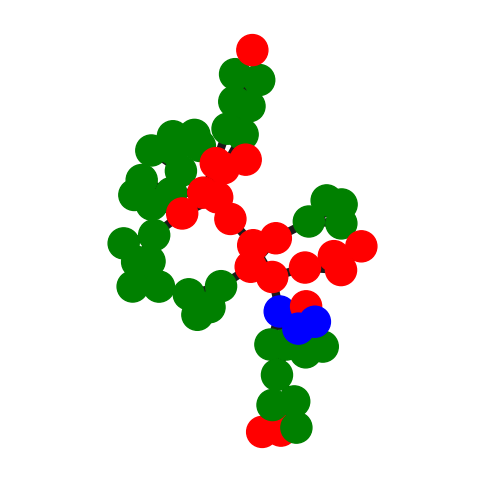

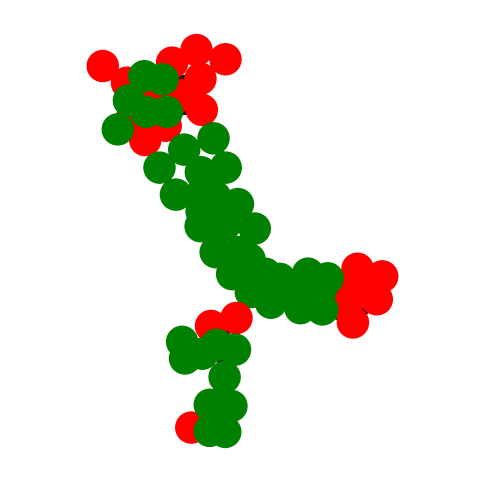

In [50]:
results = run_random_baseline_experiment(cls_1=3, cls_2=4, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [51]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.08482674, 0.03919275, 0.08680852, 0.27694727, 0.36654488,
       0.14567983]), 'std': array([0.12510066, 0.12113874, 0.18845942, 0.31664275, 0.31339225,
       0.21830826])}


#### 4 & 5

===Trial 0===
n=44 m=84
logits=[-12.757226943969727, -11.175362586975098, -16.275400161743164, -12.856727600097656, -10.431230545043945, -15.420137405395508]
probs=[0.05846046283841133, 0.2843526005744934, 0.0017335606971755624, 0.05292363464832306, 0.5984524488449097, 0.004077321384102106]
===Trial 100===
n=81 m=154
logits=[-16.015426635742188, -17.17317771911621, -17.985498428344727, -17.148069381713867, -13.3683500289917, -12.513229370117188]
probs=[0.020376212894916534, 0.00640204269438982, 0.00284139858558774, 0.006564822047948837, 0.2875638008117676, 0.6762517690658569]
===Trial 200===
n=38 m=76
logits=[-9.18321704864502, -20.081031799316406, -16.492143630981445, -7.441247463226318, -6.530258655548096, -6.64117956161499]
probs=[0.029752368107438087, 5.503773081727559e-07, 1.992025318031665e-05, 0.1698436588048935, 0.42236384749412537, 0.37801966071128845]
===Trial 300===
n=67 m=134
logits=[-13.038689613342285, -12.65531063079834, -11.832439422607422, -15.139059066772461, -10.0463

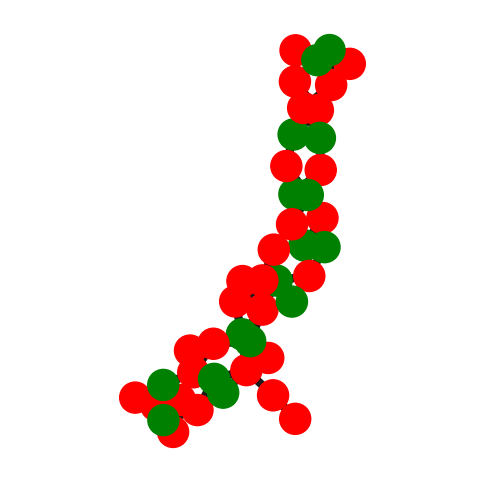

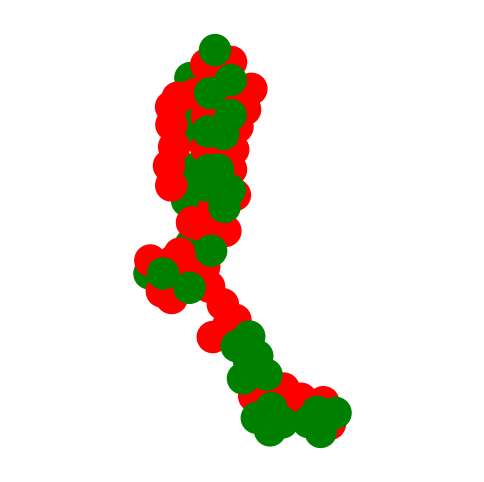

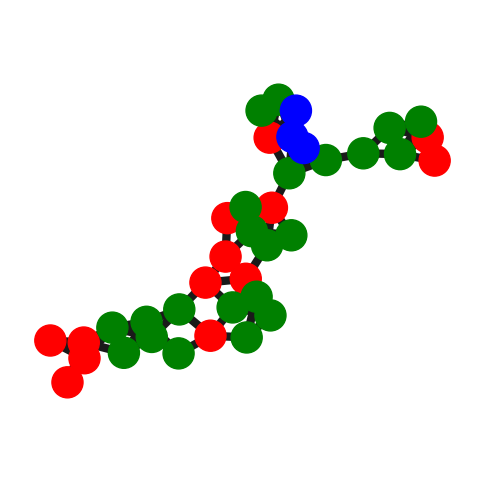

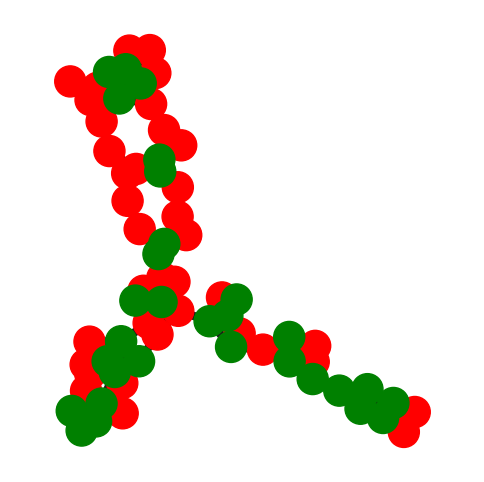

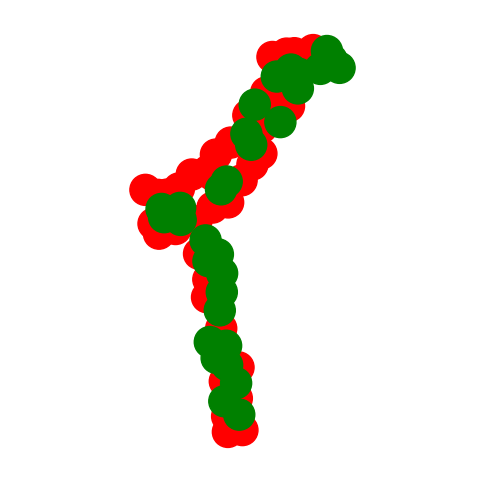

In [52]:
results = run_random_baseline_experiment(cls_1=4, cls_2=5, data=dataset_list_pred, model=model, n_trials=500, show_every=100)

In [53]:
print(results)

{'label': ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6'], 'mean': array([0.07016548, 0.06319683, 0.07558746, 0.16875639, 0.3823001 ,
       0.23999374]), 'std': array([0.10163746, 0.12191989, 0.14011596, 0.26467853, 0.29112198,
       0.24210546])}


# Proteins

In [8]:
proteins = PROTEINSDataset(seed=12345)

model = GCNClassifier(node_features=len(proteins.NODE_CLS),
                      num_classes=len(proteins.GRAPH_CLS),
                      hidden_channels=32,
                      num_layers=3)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
model.load_state_dict(torch.load('ckpts/proteins.pt', map_location=torch.device(device)))
        
dataset_list_gt = proteins.split_by_class()
dataset_list_pred = proteins.split_by_pred(model)

/opt/miniconda3/envs/gnnboundary/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l

In [10]:
results = run_random_baseline_experiment(cls_1=0, cls_2=1, data=dataset_list_pred, model=model, n_trials=500)

In [11]:
print(results)

{'label': ['No-Enzyme', 'Enzyme'], 'mean': array([0.76827002, 0.23172998]), 'std': array([0.15173854, 0.15173854])}
